In [1]:
import numpy as np
import astropy as ap
import scipy as sp
from scipy import stats
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [65]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [41]:
# Constants and other setup variables. Event rates are events/year. Spherical points should be (theta, phi)
low_energy_rate = 50
high_energy_rate = 70
low_energy_resolution = (.3, .3)
high_energy_resolution = (.3, .3)
lisa_resolution = (.3, .3)
NSIDE = 128
Npix = hp.nside2npix(NSIDE)

In [46]:
# Monte Carlo values
# time_vals = [10, 1000, 10000, 100000, 1000000]
# emri_array = [1, 100, 1000, 4000]
# mbh_array = [1,2,3]
# position_array = [1,2,3,4,5]

In [114]:
# Sample MC values
time_vals = [10, 1000]
emri_array = [100, 1000]
mbh_array = [3]
position_array = [1,2]

In [108]:
time_diff = 100000
mbh_rate = 3
emri_rate = 50
position_factor = 1

In [4]:
def add_time():
    time = np.random.randint(86400*365*1000)
    return time

In [5]:
# Get a random point on a sphere (uniform distribution). LISA should be fairly uniform and so should IceCube Gen II
def random_point():
    phi = np.random.random()*2*np.pi
    costheta = np.random.random()*2 - 1
    theta = np.arccos(costheta)
    return [theta, phi]

In [6]:
def plot_gaussian_event(etheta, ephi, sigma, amp):
    theta,phi=hp.pix2ang(NSIDE,np.arange(Npix))
    return amp*np.exp(-((phi - ephi)**2+(theta - etheta)**2)/(2*sigma**2))

In [7]:
def healpix_smooth(etheta, ephi, sig, amp):
    pind = hp.ang2pix(NSIDE, etheta, ephi)
    temp = np.zeros(Npix)
    temp[pind] = amp
    return hp.smoothing(temp, sigma=sig)

In [8]:
# Reduce redundancy! hen=True --> HEN events, hen=False --> GW events
# category depends on hen. hen=True: category = 0 --> low energy, 1 --> high energy
# hen=False, category = 0 --> EMRI, 1 --> MBH (doesn't matter for now)
def general_noise(hen, category):
    if hen:
        if category == 0:
            noise_val = low_energy_resolution
        else:
            noise_val = high_energy_resolution
    else:
        noise_val = lisa_resolution
    return np.random.normal()*np.array(noise_val)

In [9]:
def general_event(poisson_lambda, hen, category):
    points = []
    noise = []
    time = []
    k = np.random.poisson(lam=poisson_lambda)
    for i in range(k):
        points.append(random_point())
        noise.append(general_noise(hen, category))
        time.append(add_time())
    return [np.array(points), np.array(noise), np.array(time)]

In [10]:
def make_hp_map(points, noise):
    temp_map = np.zeros(Npix)
    for i,v in enumerate(points):
        temp_map += healpix_smooth(*v, np.linalg.norm(noise[i]), 1)
    return temp_map

In [11]:
def position_overlap(p1, p2, n1, n2):
    pvec1 = hp.ang2vec(*p1)
    pvec2 = hp.ang2vec(*p2)
    p1_disk = hp.query_disc(256, pvec1, n1*position_factor, inclusive=True)
    p2_disk = hp.query_disc(256, pvec2, n2*position_factor, inclusive=True)
    overlap = np.intersect1d(p1_disk, p2_disk)
    return len(overlap)

In [30]:
def time_overlap(t1,t2):
    d = {}
    for i,v in enumerate(t1):
        a = np.where(t2 < v + time_diff)[0] 
        b = np.where(t2 > v - time_diff)[0]
        c = np.intersect1d(a,b)
        if len(c) > 0:
            d[i] = c
    return d

In [31]:
def overlap(e1, n1, t1, e2, n2, t2):
    time_worthy = time_overlap(t1, t2)
    overlap_counter = 0
    pairs_overlap = []
    for i,v in enumerate(time_worthy):
        pos_1 = e1[v]
        noise_1 = np.linalg.norm(n1[v])
        for k in time_worthy[v]:
            pos_2 = e2[k]
            noise_2 = np.linalg.norm(n2[k])
            l = position_overlap(pos_1, pos_2, noise_1, noise_2)
            if l > 0:
                pairs_overlap.append((v,k))
                overlap_counter += 1

    return overlap_counter, pairs_overlap

In [32]:
def monte_carlo_run():
    low = general_event(low_energy_rate, True, 0)
    high = general_event(high_energy_rate, True, 1)
    emri = general_event(emri_rate, False, 0)
    mbh = general_event(mbh_rate, False, 1)
    l_e, _ = overlap(*low, *emri)
    l_m, _ = overlap(*low, *mbh)
    h_e, _ = overlap(*high, *emri)
    h_m, _ = overlap(*high, *mbh)
    return np.array([l_e, l_m, h_e, h_m])

In [126]:
def mc_big_hammer(n=100):
    global time_diff
    global emri_rate
    global mbh_rate
    global position_factor
    for i in time_vals:
        time_diff = i
        for j in emri_array:
            emri_rate = j
            for k in mbh_array:
                mbh_rate = k
                for l in position_array:
                    lval=[]
                    position_factor = l
                    for m in tqdm(range(n)):
                        lval.append(np.sum(monte_carlo_run()))
                        array_name = 'lval_big_time%i_emri%i_mbh%i_pos%i_%i_' % (i, j, k, l, n)
                        np.save('output/' + array_name, lval)

In [125]:
def mc(n=100):
    lval = []
    for i in tqdm(range(n)):
        lval.append(np.sum(monte_carlo_run()))
    return lval

In [127]:
n = 10
m = mc_big_hammer(n)

In [109]:
np.sum(m)

40

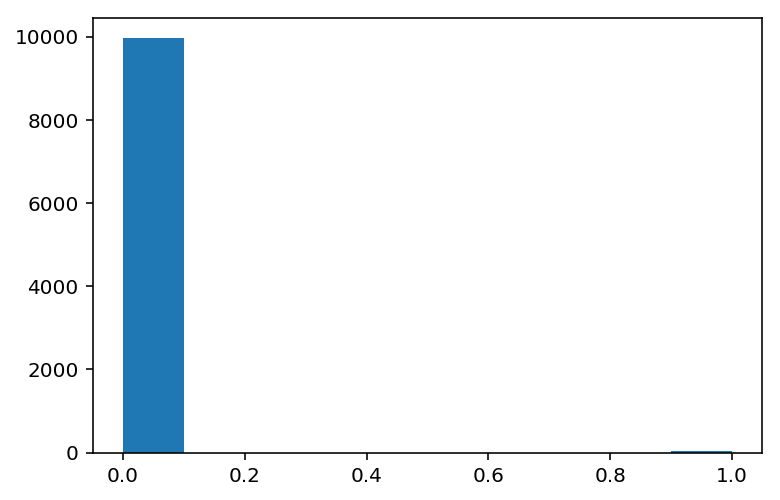

In [110]:
plt.hist(m);

In [119]:
k = np.load('output/lval_big_time1000_emri100_mbh3_pos1_n_.npy')

In [121]:
np.sum(k)

0

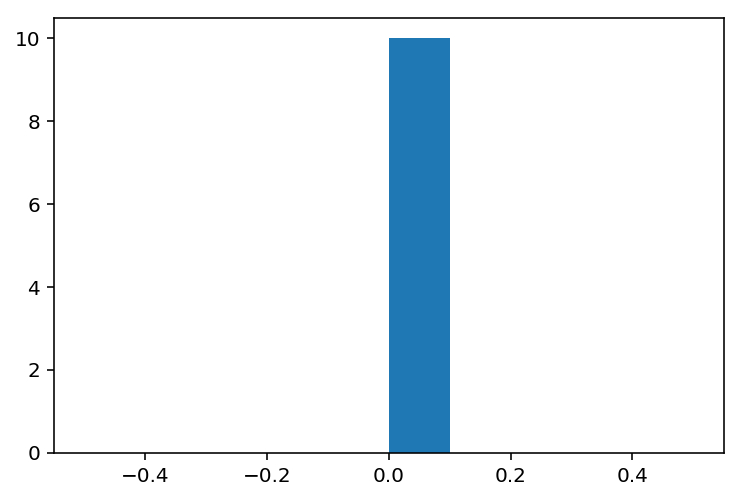

In [123]:
plt.hist(k);